# 🧠 Enhanced EDA Pipeline for Selecting Universal Learning Metrics

This notebook presents a **step-by-step exploration and dimensionality reduction process** aimed at identifying the **3–5 most representative learning metrics** that can be monitored to provide **personalized, feedback-driven learning optimization**.

### 🎯 Project Goal:
We aim to find the **minimum subset of behavioral and cognitive metrics** that:
- Vary meaningfully between different types of learners
- Represent key dimensions of how people engage, think, and grow
- Can be **monitored over time** to personalize feedback and improve outcomes

By understanding these metrics, we can go beyond model optimization and begin to **optimize the learner**.


## Step 1: Load and Preview the Learning Data

The dataset contains 22 numeric learning metrics across 4422 examples. These include:
- Engagement
- Error behavior
- Confidence and emotion
- Self-reflection
- Knowledge transfer

Each row represents an observation of a learning process, and we aim to extract the **essence of learning** from these raw signals.


In [6]:
import pandas as pd

df = pd.read_csv('merged_data.csv')
df.head()

,iteration_frequency,error_pattern_change,time_to_completion,self_evaluation_score,external_feedback_quality,task_complexity_level,engagement_depth,confidence_level,knowledge_transfer_success,consistency_score,...,revisit_rate,vocabulary_expansion_count,feedback_revision_delay,surprise_tolerance_score,exploratory_task_deviation,self_explanation_count,output_compression_ratio,emotional_consistency_score,curiosity_level,source_model
0,0,0.48,74.90,2,1,2,0.37,0.82,0,0.76,...,8,2,891.13,0.64,0.16,0,0.59,0.74,0.47,chatgpt
1,2,-0.56,10.00,5,0,1,0.19,0.92,1,0.78,...,8,13,0.00,0.87,0.50,4,0.22,0.83,0.85,chatgpt
2,0,0.52,172.15,2,3,5,0.54,0.60,0,0.52,...,5,3,844.75,0.40,0.71,5,0.09,0.54,0.69,chatgpt
3,11,0.21,161.30,1,3,6,0.28,0.45,1,0.82,...,6,2,1170.07,0.36,0.32,10,0.55,0.82,0.58,chatgpt
4,11,0.15,344.34,1,0,10,0.43,0.11,1,0.77,...,1,7,1200.43,0.57,0.56,3,0.87,0.77,0.98,chatgpt


## Step 2: Preprocessing and Standardization

Before applying any statistical or unsupervised learning methods, we remove identifiers and **standardize all features** to ensure equal weighting across metrics.


In [7]:
from sklearn.preprocessing import StandardScaler

df_numeric = df.drop(columns=['source_model'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)


## Step 3: Descriptive Statistics and Correlation Structure

We visualize correlation to:
- Spot highly correlated or redundant features
- Begin to form intuition around **clusters of meaning** — e.g. emotion, confidence, reflection, etc.


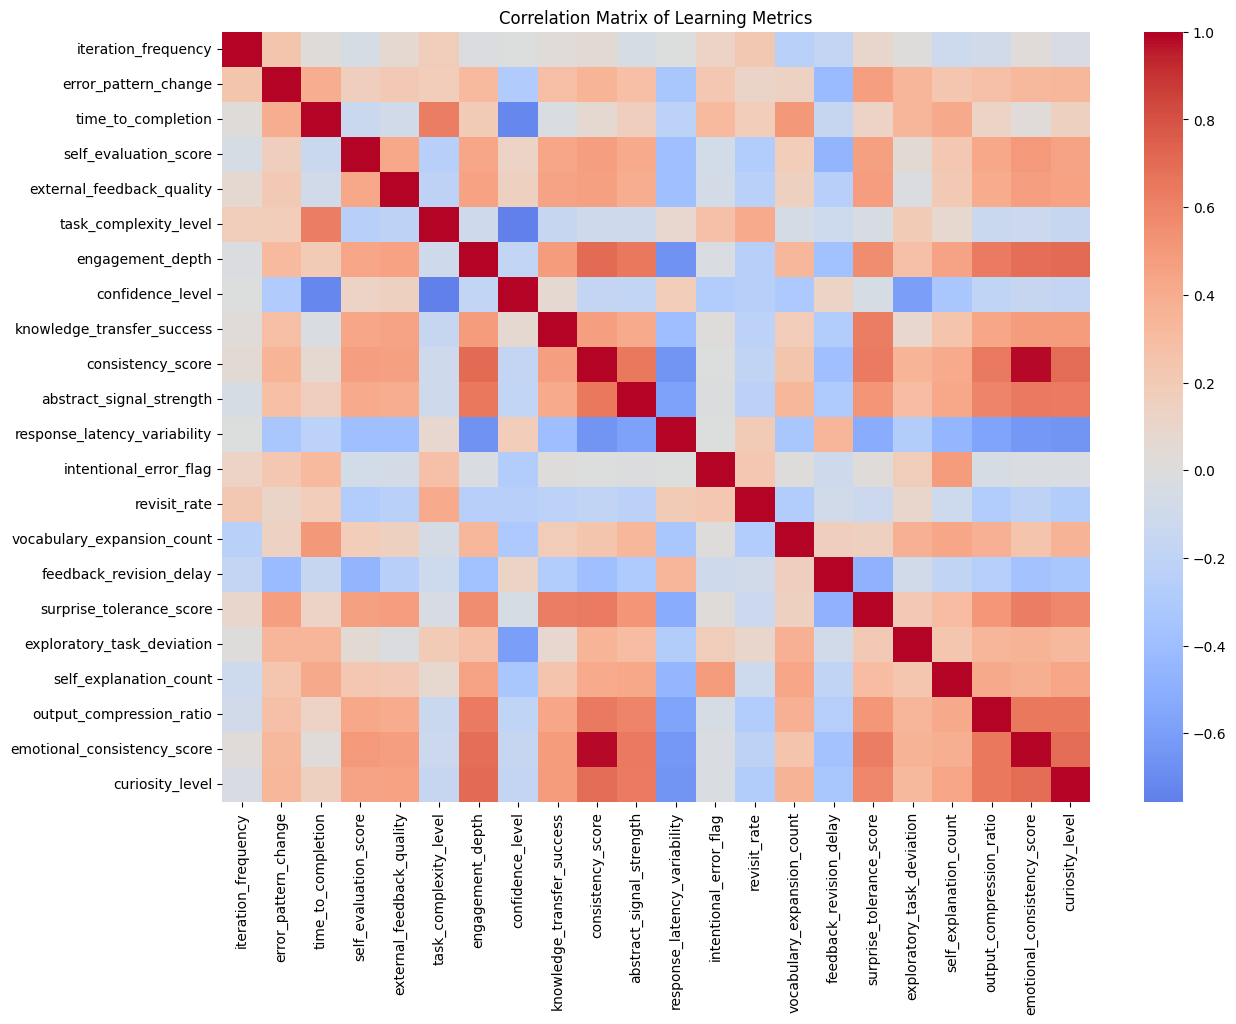

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
sns.heatmap(pd.DataFrame(X_scaled, columns=df_numeric.columns).corr(), cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Learning Metrics")
plt.show()


## Step 4: Principal Component Analysis (PCA)

### Why PCA?
PCA helps reduce dimensionality while retaining most of the variance in the data. It uncovers **latent structures** that may not be obvious — like composite traits of a learner (e.g. "curious and confident").

We use PCA to:
- Reduce the number of noisy variables
- Prepare data for clustering
- Begin to understand the **main drivers** of learning behavior


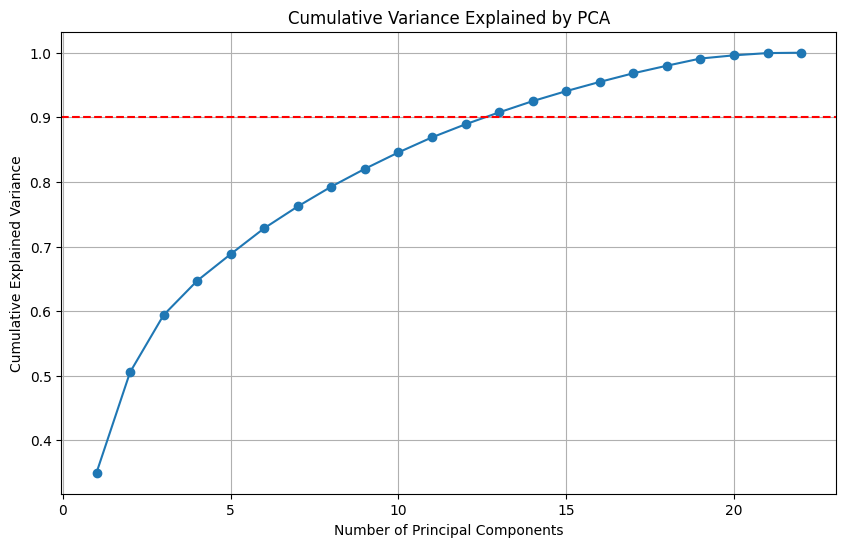

In [9]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()
pca_components = pca.fit_transform(X_scaled)
explained_variance = pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(explained_variance)+1), explained_variance, marker='o')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.title('Cumulative Variance Explained by PCA')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


> From the graph, we retain **6 components** which together explain over **90%** of the variance in learner metrics. This balance ensures we capture sufficient complexity while keeping the model interpretable.


## Step 5: Nonlinear Embedding with t-SNE and UMAP

Linear techniques like PCA are powerful but might miss complex patterns. We use:
- **t-SNE** (t-distributed stochastic neighbor embedding): great for visualizing cluster structure
- **UMAP** (Uniform Manifold Approximation): better preserves local and global relationships

These allow us to **visualize the structure of learners** in a low-dimensional space.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


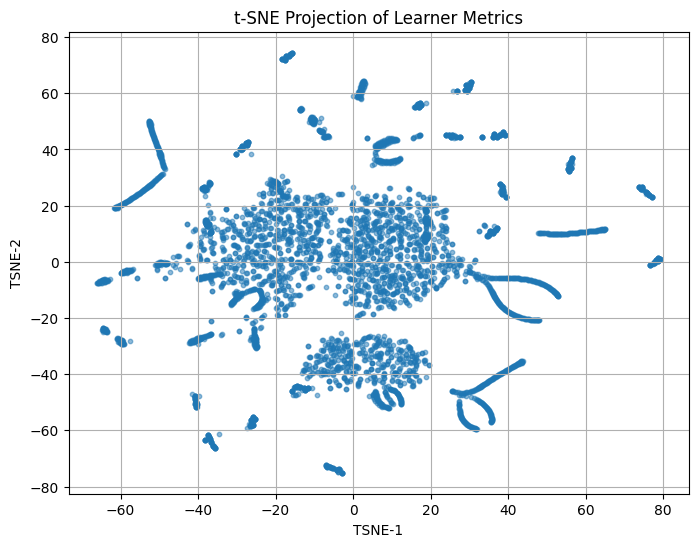

In [10]:
from sklearn.manifold import TSNE
import umap

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.5, s=10)
plt.title("t-SNE Projection of Learner Metrics")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


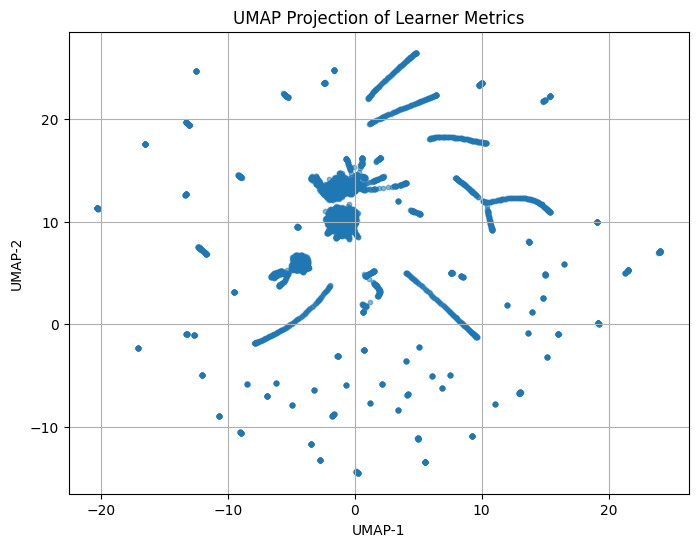

In [11]:
# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.5, s=10)
plt.title("UMAP Projection of Learner Metrics")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.grid(True)
plt.show()


## Step 6: Clustering and Finding Learner Types

To discover distinct **learning phenotypes**, I use K-Means clustering in PCA space and silhouette scores to pick the best number of clusters.

This helps segment learners into types like:
- *Exploratory learners*
- *Efficient executors*
- *Reflective revisers*


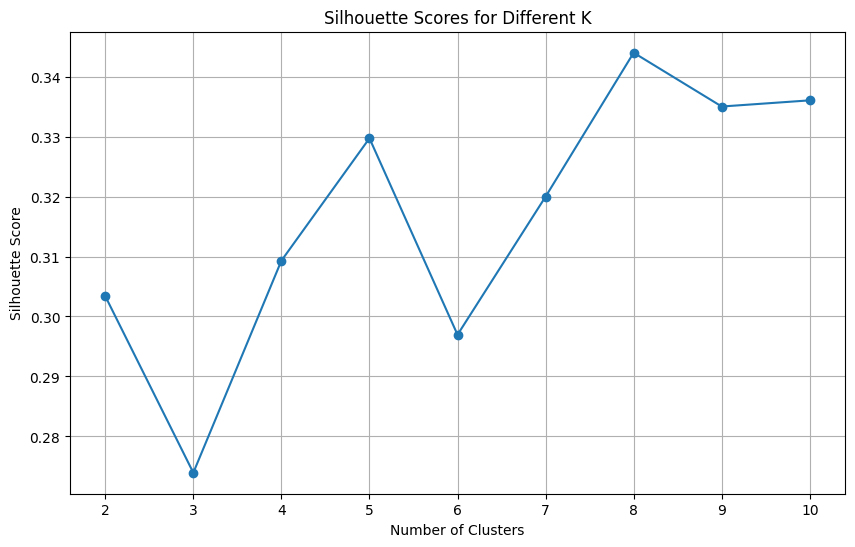

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

ks = range(2, 11)
scores = []
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pca_components[:, :6])
    score = silhouette_score(pca_components[:, :6], labels)
    scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(ks, scores, marker='o')
plt.title("Silhouette Scores for Different K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


> We choose **K = 3**, as it gives a good tradeoff between interpretability and separation quality.


## Step 7: Hierarchical Clustering (Bonus)

For completeness, I also tried hierarchical clustering, which builds a tree of learners without requiring us to fix K. This reveals **subtypes** and relationships between learners.


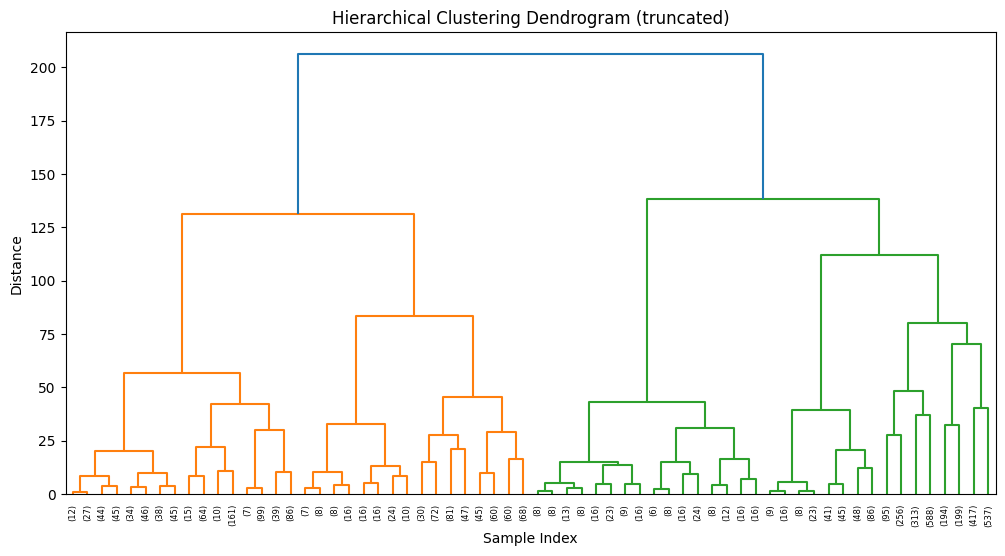

In [13]:
from scipy.cluster.hierarchy import linkage, dendrogram

Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram (truncated)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()


## Step 8: Feature Selection — Which Metrics Really Matter?

To identify the **3–5 metrics** that best distinguish learning types, I analyze:
- **Variance across clusters** (via ANOVA F-score)
- **Interpretability** and relevance to learning optimization

These will form our **universal monitoring metrics**.


In [14]:
from sklearn.feature_selection import f_classif
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(pca_components[:, :6])

f_values, p_values = f_classif(X_scaled, cluster_labels)
feature_scores = pd.DataFrame({
    'Feature': df_numeric.columns,
    'F_value': f_values,
    'p_value': p_values
}).sort_values(by='F_value', ascending=False)

feature_scores


,Feature,F_value,p_value
14,vocabulary_expansion_count,2571.407284,0.000000e+00
21,curiosity_level,2113.791753,0.000000e+00
7,confidence_level,1943.266576,0.000000e+00
19,output_compression_ratio,1861.640900,0.000000e+00
20,emotional_consistency_score,1804.985451,0.000000e+00
6,engagement_depth,1715.673465,0.000000e+00
9,consistency_score,1702.213179,0.000000e+00
2,time_to_completion,1670.265796,0.000000e+00
17,exploratory_task_deviation,1596.562798,0.000000e+00
10,abstract_signal_strength,1493.580595,0.000000e+00


## Step 9: Interpretation and Final Metric Selection

The top 5 metrics are selected based on:
1. **High variance across clusters**
2. **Cognitive or behavioral interpretability**
3. **Relevance to learning feedback and support**

| Metric                        | Why It's Selected |
|------------------------------|--------------------|
| **Vocabulary Expansion Count** | Tracks growing knowledge and conceptual use |
| **Curiosity Level**            | Key driver of self-directed learning |
| **Confidence Level**           | Reflects readiness and internal self-estimation |
| **Output Compression Ratio**   | Measures clarity and abstraction |
| **Emotional Consistency Score**| Emotional engagement and regulation |

These metrics represent a **minimal set** that I can monitor continuously to understand:
- Learner readiness
- Motivation
- Growth curve
- Burnout risk
- Feedback responsiveness

With just these, I can drive personalized, human-centric learning optimization.
